# Esercitazione 7

In questa esercitazione vogliamo approfondire la dinamica molecolare trattata nell'Esercitazione 4 applicando, innanzitutto, le correzioni di coda per l'energia potenziale e la pressione; introdurremo, poi, il calcolo della funzione distribuzione radiale $g(r)$ e confronteremo i risultati ottenuti utilizzando l'algoritmo di Metropolis con quelli dati dalla risoluzione delle equazioni di Newton.

### Ensemble Canonico

A differenza dell'esercitazione 4, in cui simulavamo il nostro sistema di particelle attraverso la risoluzione delle Equazioni di Newton, qui vogliamo applicare l'algoritmo di Metropolis. Ci poniamo, perciò, in un ensemble canonico in cui, oltre al numero di particelle e al volume, si mantiene costante anche la temperatura grazie al contatto termico con un serbatoio di calore che, avendo capacita' termica molto maggiore di quella del nostro sistema, compensa le variazioni di temperature del nostro sistema continuando a scambiare calore con esso. \
Ad ogni stato i del sistema canonico è associata la seguente probabilità:

$$ P_i= \frac{e^{-\beta E_i}}{Z} $$ con $Z = \sum_{i}e^{-\beta H}$ funzione di partizione.


## Esercizio 7.1

Nell'esercitazione 4 avevamo brutalmente ipotizzato che se coppie di particelle nella scatola di simulazione erano più lontane di $r_{cutoff}$, allora il loro potenziale di interazione era nullo: sostanzialmente non sentivano la presenza dell'altra. \
Stiamo, perciò, "troncando" il Potenziale di Lennard-Jones ad un certo r della zona attrattiva a lungo raggio: come conseguenza il nostro metodo sovrastima la pressione perchè sottostima la parte attrattiva tra le coppie di particelle. 

Per andare a calcolare correttamente le proprietà termodinamiche a cui siamo interessati, come l'energia potenziale e la pressione del sistema, dobbiamo correggere le nostre approssimazioni con le cosiddette "Tail Corrections". \
Integriamo, quindi, le nostre quantità tra il raggio di cutoff e l'infinito e, per un potenziale di coppia di Lennard-Jones, troviamo che le correzioni, scritte in unità naturali, sono pari a:
$$\frac{U_{tail}}{N} = 8\pi\rho\left(\frac{1}{9r_{cut}^9}-\frac{1}{3r_{cut}^3}\right) \qquad\qquad P_{tail}=\frac{W_{tail}}{3N} = 32\pi\rho^2\left(\frac{1}{9r_{cut}^9}-\frac{1}{6r_{cut}^3}\right)    $$

dove $\rho$ è la densità del nostro gas e $W$ è il viriale, legato al calcolo della Pressione.

Implementiamo quindi le correzioni di coda nel codice.

### Equilibrizzazione

Prima di poter procedere con la esercitazione, dobbiamo far girare la nostra simulazione per un tempo, quindi un numero di step, sufficiente affinche' raggiunga l'equilibrio alla temperatura desiderata. Lavorando in ensemble canonico in se' la temperatura non variera', ma il sistema impieghera' un certo numero di passi per spostarsi dalla configurazione di cristallo perfetto, che la funzione di input impone come configurazione iniziale, alla sua configurazione stabile.

Per andare ad osservare dopo quanti passi il sistema nella fase voluta raggiunge l'equilibrio eseguiamo una simulazione con 5000 blocchi ognuno da uno step e analizziamo i valori istantanei step by step di energia interna per numero di particelle. \
A differenza del Modello di Ising 1D in Ensemble Canonico, in cui riconoscevamo il raggiungimento dell'equilibrio da un plateau delle grandezze, qui l'energia interna continuera' ad oscillare. \
L'equilibrizzazione, quindi, mira piu' che altro allo scartare evidenti trend incoerenti col resto dell'andamento.


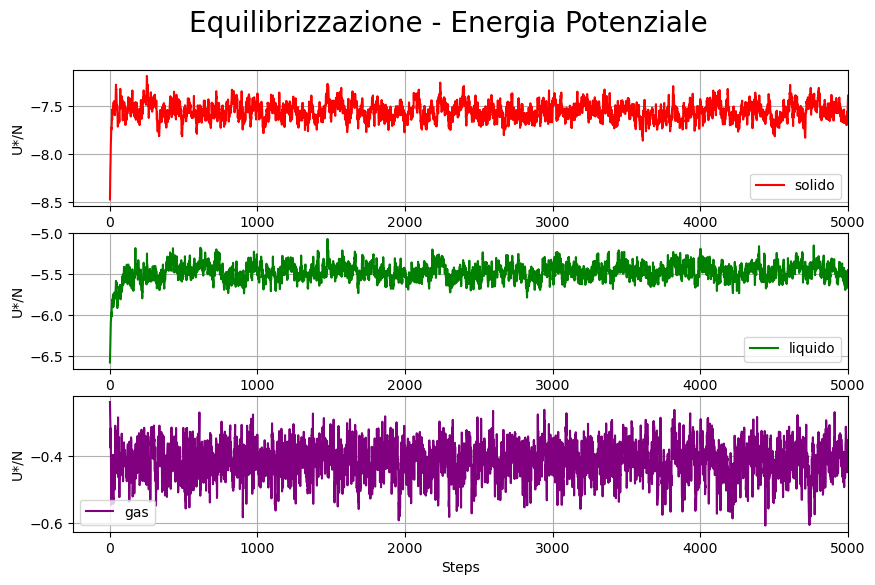

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

N =5000
x = np.arange(N)+1 
plt.figure(figsize=(10,6))
fase = ["solido", "liquido", "gas" ]
colors = ['red', 'green', 'purple']
for i in range (3) :
    u= np.loadtxt("es7.2/" + fase[i]+ "/Eq/output_epot.dat", usecols=(2), unpack=True, delimiter=' ')
    plt.subplot(3, 1, i+1)
    plt.plot(x,u, label = fase[i], color=colors[i])
    plt.grid(True)
    plt.xlabel('Steps', fontsize=10)
    plt.xlim(right=5000)
    plt.ylabel('U*/N', fontsize=10)
    plt.legend(fontsize="10")
    
plt.suptitle('Equilibrizzazione - Energia Potenziale', fontsize=20)
plt.show()

Possiamo osservare come siano evidenti trend da scartare solo negli step iniziali di tutte tre le fasi. Dopo circa 2000 passi, possiamo ritenere quindi il sistema sempre equilibrato con l'energia interna che oscilla intorno a valori pressoche' costanti senza mai allontanarsi troppo da essi. 

Abbiamo, percio', preferito eseguire all'inizio del programma un ciclo di 2000 steps, dove ogni step e' un ciclo di 108 tentativi di muovere una particella a caso, in cui il sistema viene lasciato equilibrarsi piuttosto che far ripartire il sistema da una configurazone gia' equilibrata salvata in un file esterno. \
Solo dopo l'equilibrizzazione, la simulazione vera e propria puo' partire.

## Esercizio 7.2

Ora che abbiamo migliorato la nostra approssimazione e termalizzato il sistema, studiamo i valori istantanei dell'energia potenziale per particella generando una simulazione di $5\times10^5$ blocchi da uno step per un sistema di Argon, $\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu, in 3 fasi differenti:
1. fase solida: $\rho^* = 1.1$ , $T^* = 0.8$ , $r_c = 2.2$;
2. fase liquida: $\rho^* = 0.8$ , $T^* = 1.1$ , $r_c = 2.5$;
3. fase gassosa: $\rho^* = 0.05$ , $T^* = 1.2$ , $r_c = 5.0$.

Dato che utilizziamo l'algoritmo di Metropolis dobbiamo sostituire nel file di input il passo di integrazione temporale per l'algoritmo di Verlet col passo del Metropolis, cioe' di quanto spostare la singola particella per poi vedere se la mossa e' accettabile. Dobbiamo, quindi, provare con vari valori fino a trovare un passo per cui l'acceptance rate sia intorno al 50%. \
Riportiamo i passi trovati per le tre fasi che andremo a studiare:
1. fase solida: 0.115;
2. fase liquida: 0.21;
3. fase gassosa: 6.

Dobbiamo evidenziare come nel caso del gas, nonostante i molti tentativi, non si riesca a scendere ad un acceptance rate del 50%, ma si rimane intorno al 60%. Abbiamo impostato, percio', il passo del Metropolis piu' grande possibile cioe' pari alla meta' del lato della box di simulazione.

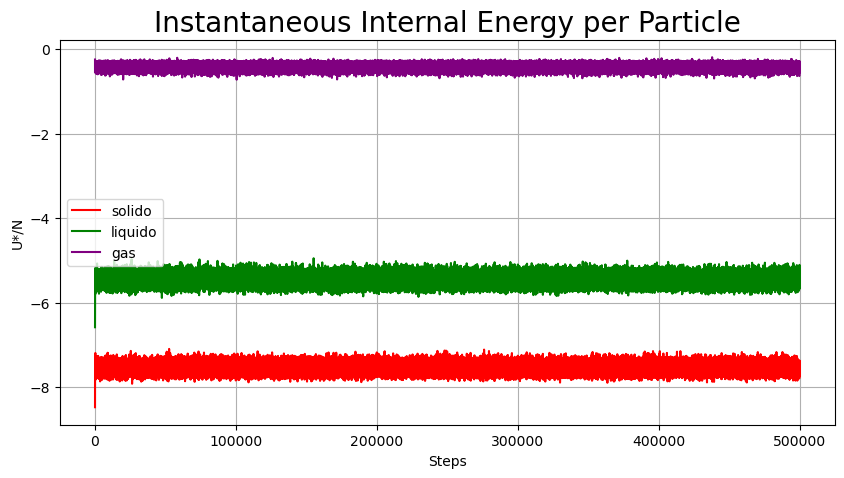

In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

N =500000
x = np.arange(N)+1
plt.figure(figsize=(10,5))
fase = ["solido", "liquido", "gas" ]
colors = ['red', 'green', 'purple']
for i in range (3) :
    u= np.loadtxt("es7.2/"+ fase[i]+ "/output_epot.dat", usecols=(2), unpack=True, delimiter=' ')
#second column cause we plot the value in each block and not the progressive average after 1block, 2blocks and so on
    plt.plot(x,u, label = fase[i], color=colors[i])
    
plt.title('Instantaneous Internal Energy per Particle', fontsize=20)
plt.grid(True)
plt.xlabel('Steps', fontsize=10)
#plt.xlim(left=1000, right=2000)
plt.ylabel('U*/N', fontsize=10)
plt.legend(fontsize="10")

plt.show()

### Autocorrelazione

Nelle nostre simulazioni basate sull'algoritmo di Metropolis e' chiaro che se eseguiamo due misurazioni dell'energia interna separate da un singolo step Monte Carlo, i valori verranno molto simili e sara' presente una importante correlazione tra le misure. Per avere campionamenti statisticamente indipendenti dobbiamo, invece, estrarre valori dell'energia interna ad intervalli maggiori di circa due volte il tempo di correlazione $t_c$, dove $t_c$ e' il tempo a cui la funzione che descrive l'autocorrelazione e' diminuita di un fattore 1/e. 

Percio', per realizzare il data blocking in maniera efficiente ed estrapolare misurazioni indipendenti, dobbiamo stimare $t_c$ in unita' di step del Monte Carlo e porre il numero di step in ogni blocco molto maggiore di $2t_c$. 

Utilizziamo, quindi, il dataset precedentemente acquisito di $5\times10^5$ misurazioni istantanee di $U/N$ per andare ad analizzare la funzione di autocorrelazione:

\
$$\chi (t) = \frac{\frac{1}{t_{max}-1}\sum_{t'=0}^{t_{max}-t}m(t')m(t'+t)-\frac{1}{t_{max}-1}\sum_{t'=0}^{t_{max}-t}m(t')\times\frac{1}{t_{max}-1}\sum_{t'=0}^{t_{max}-t}m(t'+t)}{\frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}m^2(t') - \left( \frac{1}{t_{max}}\sum_{t'=0}^{t_{max}}m(t') \right)^2 } $$

\
dove m e' l'energia interna per particella e t rappresenterebbe il tempo, ma per i nostri interessi descrive il numero di step della simulazione Monte Carlo.

Plottiamo l'andamento della funzione di Autocorrelazione in funzione del numero di passi per le tre fasi del sistema di Argon in precedenza simulato. \
Ci aspettiamo che la funzione di Autocorrelazione decada esponenzialmente a zero per tempi tendenti all'infinito. Per questo analizziamo l'andamento fino a $t_{max}=300$; tempi piu' lunghi renderebbero solo piu' dispensiosa, in termine di tempo di esecuzione, l'analisi.

In [62]:
def auto_correlation (t, t_max, pot =[]) : #pot e' l'array di dati del potenziale del solido, liquido o del gas
    #Pot e' passato cosi' perche' e' una lista
    prefattore_1 = 1/(t_max-t)
    prefattore_2 = 1/t_max
    fattore_1=0
    fattore_2=0
    fattore_3=0
    fattore_4=0
    fattore_5=0
    for i in range (t_max -t) :
        fattore_1 += pot[i]*pot[i+t]
        fattore_2 += pot[i]
        fattore_3 += pot[i+t]        
    for j in range (t_max) :
        fattore_4 += pot[j]*pot[j]
        fattore_5 += pot[j]   

    num = prefattore_1*fattore_1 - prefattore_1*fattore_2*prefattore_1*fattore_3
    den = prefattore_2*fattore_4 - (prefattore_2*fattore_5)*(prefattore_2*fattore_5)
    chi = num/den
    return chi

<function matplotlib.pyplot.show(close=None, block=None)>

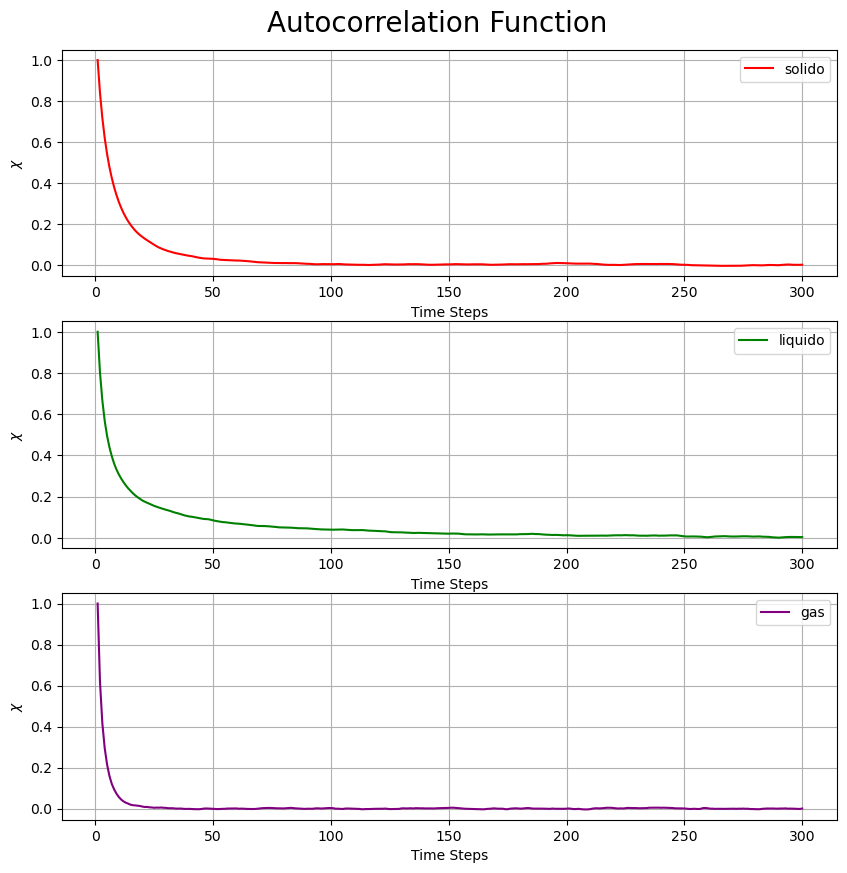

In [78]:
t_max = 300
N=500000
x = np.arange(t_max)+1
fase = ["solido", "liquido", "gas" ]
colors = ['red', 'green', 'purple']
plt.figure(figsize=(10,10))

for f in range (0, 3) :
    Chi = [] #Declaration of a list
    pot = np.loadtxt("es7.2/"+ fase[f]+ "/output_epot.dat", usecols=(2), unpack=True, delimiter=' ')
    for t in range (t_max) :
        Chi.append(auto_correlation(t, N, pot))
        #Chi[t] = auto_correlation(t, N, pot)
        #if t%1==0:
         #   print(t, end= ", ")
    plt.subplot(3, 1, f+1)
    plt.plot(x, Chi, label = fase[f], color= colors[f])
    plt.grid(True)
    plt.xlabel('Time Steps', fontsize=10)
    plt.ylabel(r'$\chi$', fontsize=10)
    plt.legend()

plt.suptitle('Autocorrelation Function', fontsize=20, y=0.92)
plt.show
#circa 10 minuti di runtime

Possiamo osservare come in tutti e tre i casi il tempo di correlazione e' intorno alla ventina di Monte Carlo steps. \
Questo significa che, se scegliessimo come numero di passi per blocco un numero minore di quello per cui c'e' autocorrelazione, i blocchi sarebbero tutti fortemente correlati e sottostimeremo sistematicamente l'incertezza statistica sulle medie progressive del metodo a blocchi.

## Incertezza Statistica

Possiamo, inoltre, utilizzare lo stesso set di dati per studiare la stima delle incertezze statistiche dei valori attesi di $U/N$ in funzione delle diverse grandezze dei blocchi, quindi numero di step, da utilizzare in un metodo a blocchi. \
Vogliamo, perciò, dividere i nostri $5\times10^5$ dati in blocchi, in numero da 100 a 50000, in cui ognuno avrà rispettivamente un numero di steps pari a $L=M/N$ con $M=5\times10^5$ e N il numero dei blocchi; L, quindi, variera' tra $10$ e $5\times10^3$.

Plottiamo, quindi, l'andamento delle incertezze statistiche trovate, implementando il data blocking, in funzione del numero di step per blocco L.

In [87]:
def Error(global_avg, glob_avg2, iblk): #iblk indice di blocco
    if iblk == 0 :
        return 0
    return np.sqrt(abs(glob_avg2 - pow(global_avg,2))/iblk)

def block_method(blk_number, blk_lenght, pot = []): #lenght vuol dire steps
    glob_ave=0
    glob_ave2=0
    error=0
    for n in range(blk_number): #ciclo sui blocchi
        blk_ave=0
        for i in range(blk_lenght): #ciclo sugli step per blocco
            blk_ave += pot[i + n*blk_lenght] #primo ciclo somma sui primi l, poi sui secondi l e cosi' via
            
        blk_ave=blk_ave/blk_lenght
        glob_ave += blk_ave
        glob_ave2 += (blk_ave*blk_ave)
        error=Error(glob_ave/(n+1), glob_ave2/(n+1), n)
    return error

<function matplotlib.pyplot.show(close=None, block=None)>

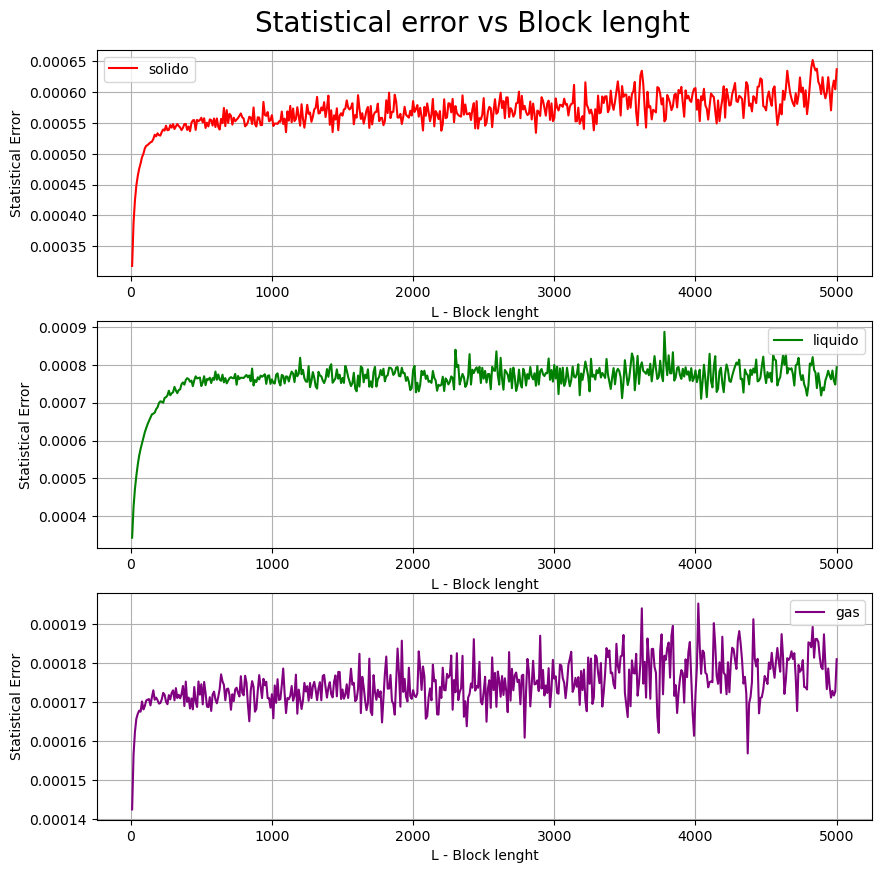

In [95]:
fase = ["solido", "liquido", "gas" ]
colors = ['red', 'green', 'purple']
plt.figure(figsize=(10,10))
L_min=10
L_max=5000
M=500000
L = np.arange(L_min, L_max +10, 10) #da 10 a 5000 a step di 10. l_max +10 perche' cosi' studia il caso L=5000

for i in range(0,3): #ciclo su solid, liquido o gas
    pot = np.loadtxt("es7.2/"+fase[i]+"/output_epot.dat", usecols = (2), delimiter=' ', unpack = True)
    error= [] #se qui faccio error=np_zeros(500) poi lo devo trattare come un array e non una lista e quindi mettere error[l]=block_method
    for l in L: 
        N=int(M/l)
        error.append(block_method(N, l, pot))
        
    plt.subplot(3, 1, i+1)
    plt.plot(L, error, label = fase[i], color= colors[i])
    plt.xlabel('L - Block lenght', fontsize=10)
    plt.ylabel('Statistical Error', fontsize=10)
    plt.grid(True)
    plt.legend()
    
plt.suptitle("Statistical error vs Block lenght", fontsize=20, y=0.92) 
plt.show
#circa 6 minuti di runtime

Osserviamo come, andando ad un numero di step per blocco sufficientemente grande rispetto al tempo di correlazione trovato studiando la funzione di autocorrelazione, l'incertezza statistica segue una curva che satura ad un valore finito, oscillando attorno ad un valore costante: questo vuol dire che essa non e' piu' sottostimata e i blocchi non sono piu' tra loro correlati. \
Possiamo, invece, notare come se siamo ad un numero di step basso rispetto al tempo di correlazione, l'incertezza statistica e' sottostimata e i blocchi sono tra loro correlati.

In base a questa analisi basata sul calcolo della funzione di autocorrelazione e sullo studio dell'andamento dell'incertezza statistica in funzione della lunghezza dei blocchi, possiamo affermare che per implementare in maniera efficiente e sapiente il data blocking dovremo avere almeno 2000 step per blocco.

## Esercizio 7.3

Studiando il sistema di Argon, possiamo non solo analizzare quantita' macroscopiche come la pressione o la temperatura, ma anche quantita' microscopiche come ad esempio la Funzione di Distribuzione Radiale o di coppia $g(r)$. \
Essa ci da' la probabilita' di trovare una coppia di atomi a distanza r tra loro: descrive microscopicamente come varia la densita' di materia in funzione della distanza da un punto assegnato. La conoscenza della funzione di distribuzione radiale e' particolarmnete utile perche', attraverso un semplice integrale monodimensionale, permette di calcolare il valore di aspettazione di funzioni a molti corpi come il Potenziale che governa il nostro sistema.

Per calcolare la $g(r)$ sfruttiamo l'ipotesi di studiare un fluido omogeneo in cui la funzione $g$ non dipende dalla particolare direzione tra due vettori $r_i$ $r_j$, ma solo dal modulo della differenza tra i due e troviamo che la sua espressione analitica e':

$$g(r) = \frac{1}{\rho N\Delta V(r)}\langle\sum\sum_{i\neq j=1}^{N}\delta \left(|\vec r| - |\vec r_i - \vec r_j|\right)\rangle$$

dove N e' il numero di particelle e $\Delta V(r) = \frac{4\pi}{3}[\left(r+dr\right)^3 - r^3] $ e' il volume della crosta sferica tra $r$ e $r+dr$ che normalizza la misurazione in ogni bin dovuta al fatto che non esiste un bin per ogni possibile distanza radiale, ma essi hanno una larghezza discreta.

Vogliamo, percio', implementare il calcolo di $g(r)$ con $r \in \left[ 0; L/2\right]$, che ci definisce la grandezza dei bin, nel nostro codice sfruttando il data blocking per avere il suo valor medio in ogni blocco, valor medio finale e incertezze associate. \
Per implementarlo abbiamo sfruttato il vettore di proprieta' del codice dividendo l'intervallo di $r$ in 100 sotto-intervalli, bin, e ciclando su tutte le coppie non ripetute di particelle abbiamo aggiunto +2, per contare entrambe le particelle, nel bin corrispondente ad un certo $r*$ per ogni coppia di particelle ad una distanza tra $r^*$ e $r^*+dr$: $dr$ e', quindi, la grandezza di ogni singolo bin.

## Esercizio 7.4

Ora che abbiamo implementato nel codice non solo le correzioni di coda per l'energia interna e per la pressione e il calcolo della funzione di distribuzione radiale, ma anche studiato come implementare il data blocking per avere misure indipendenti e con una incertezza non sottostimata, possiamo effettuare una simulazione completa di dinamica molecolare sfruttando l'Algoritmo di Metropolis in ensemble canonico. \
Simuliamo, ancora una volta, un sistema di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) soggetto al potenziale di coppia di Lennard-Jones in 3 condizioni differenti:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$, $r_c = 2.2$, passo Metropolis: 0.11;
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$, $r_c = 2.5$, passo Metropolis: 0.205;
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$, $r_c = 5.0$, passo Metropolis: 6.

Plottiamo, di seguito, per le tre differenti fasi l'andamento, in unita' naturali, di energia interna per particella, $U^*/N$, di pressione, $P^*$, in funzione del numero di blocchi, e della funzione di distribuzione radiale. Inoltre, confrontiamo la $g(r)$ ottenuta in ensemble canonico sfruttando il Metropolis con quella calcolata utilizzando l'algoritmo di Verlet per la risoluzione delle Equazioni del Moto in ensemble microcanonico. \
Per quanto riguarda come si e' portata avanti la simulazione con l'algoritmo di Verlet, abbiamo utilizzato la stessa procedura dell'Esercitazione 4 ripartendo da una configurazione in precedenza termalizzata affinche' la temperatura del sistema oscillasse intorno alla temperatura di simulazione desiderata: abbiamo studiato l'andamento delle temperatura istantanea per 30000 steps nel caso del solido e del liquido e per 50000 steps per il gas. In seguito, abbiamo implementato semplicemente le correzioni di coda e il calcolo della $g(r)$.

Per il calcolo utilizziamo il metodo a blocchi con 60 blocchi da 3000 step ognuno, come suggerito dagli studi effettuati poco piu' sopra.

### Fase Solida

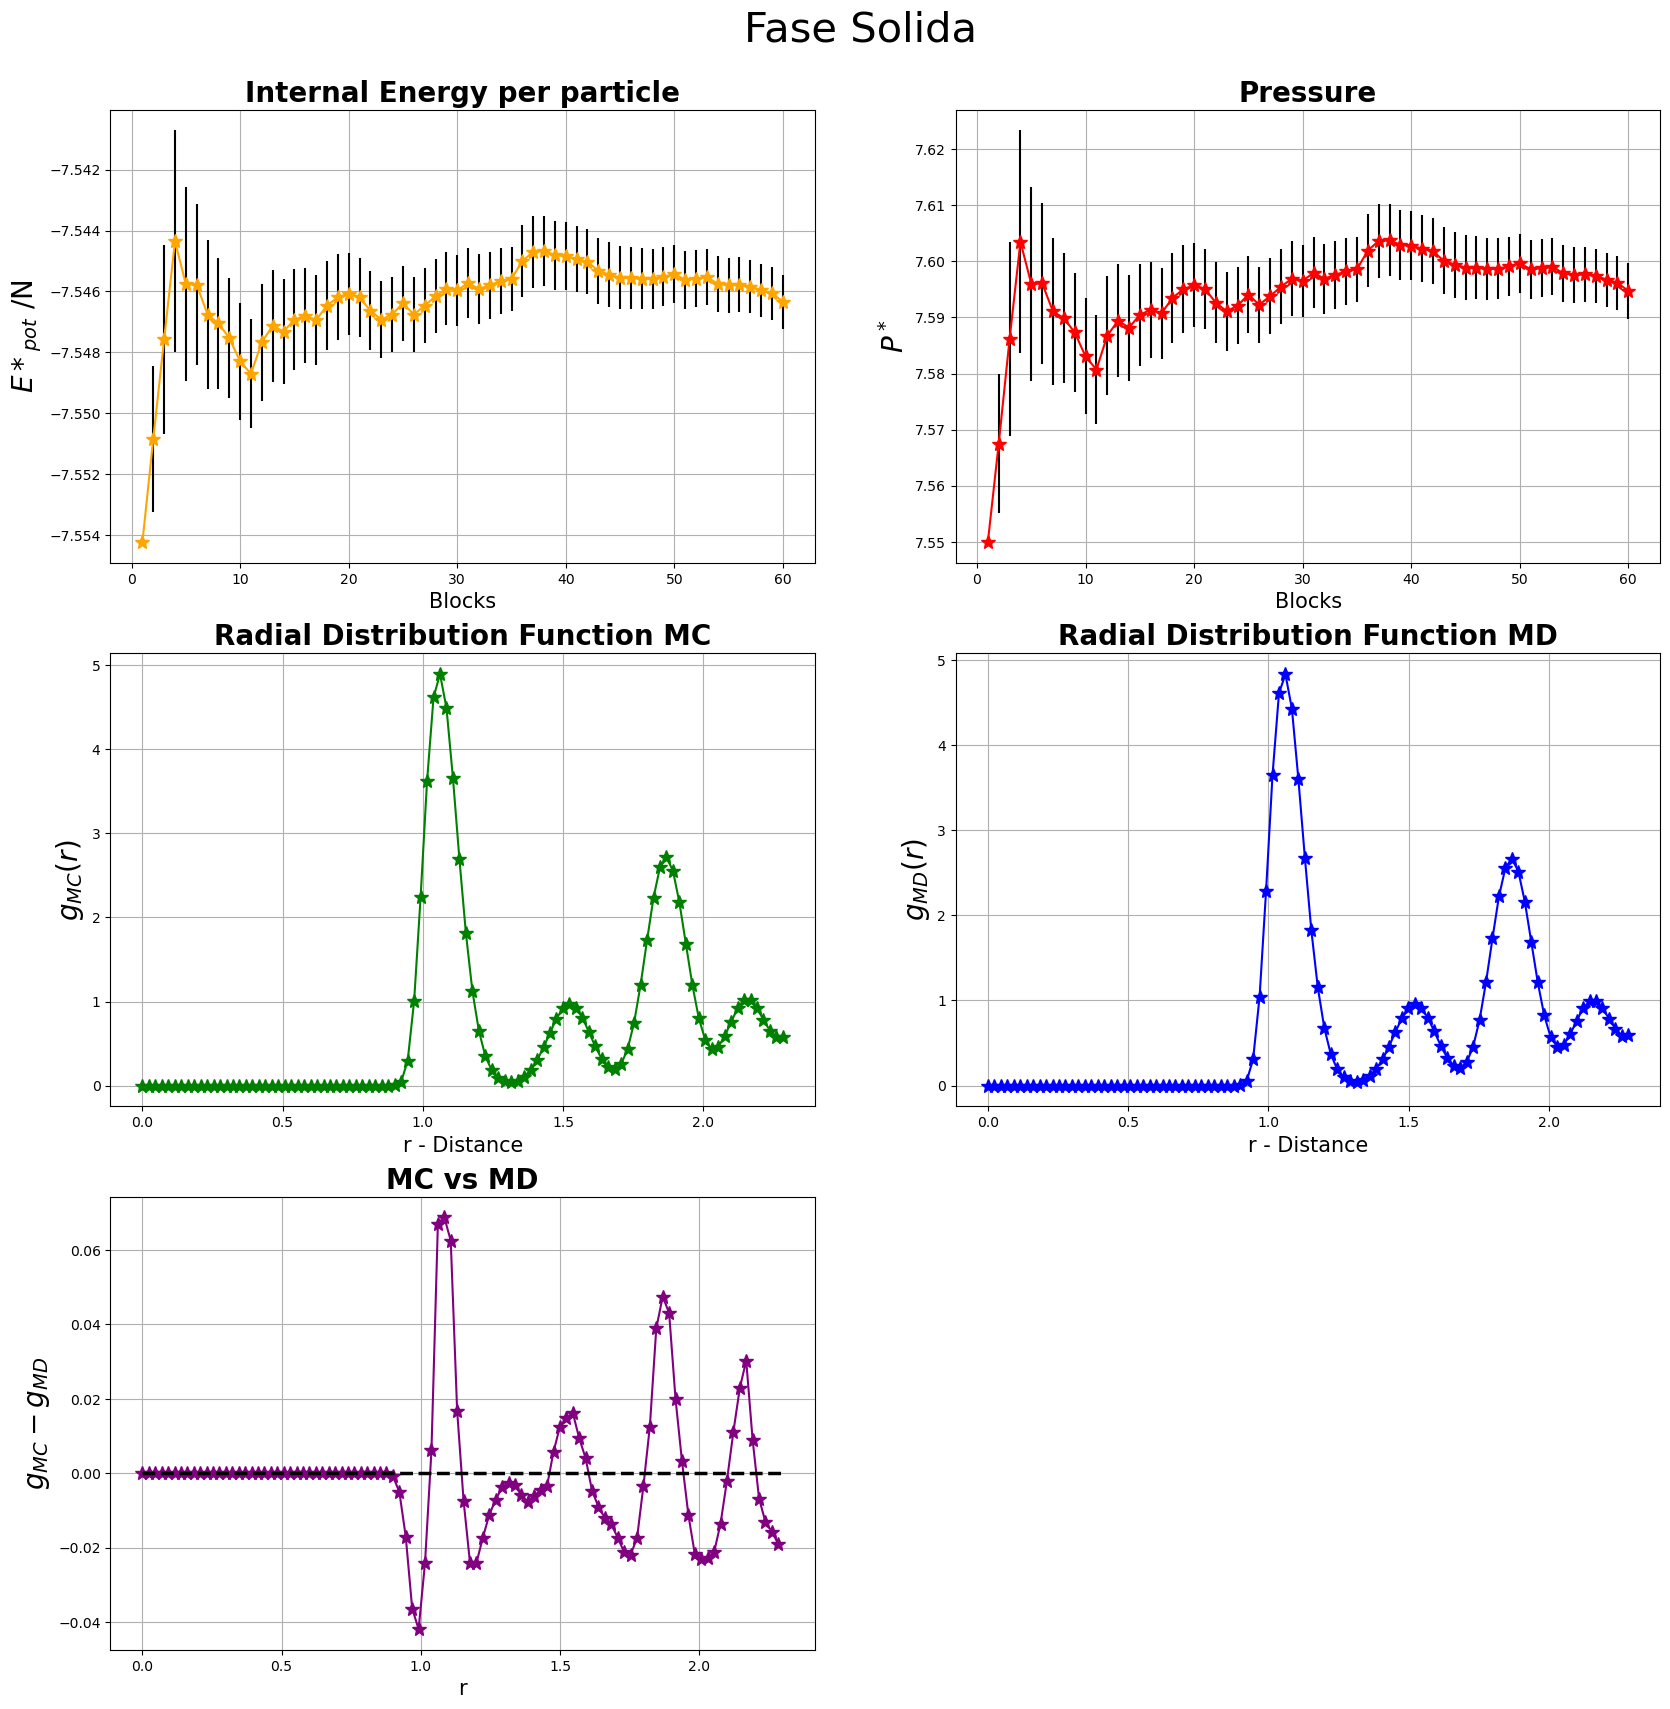

In [115]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

N =60
x = np.arange(N)+1 
plt.figure(figsize=(20,20))
colors = ['orange','red', 'green', 'blue', 'purple']
titles = ["Internal Energy per particle", "Pressure", "Radial Distribution Function MC", 
          "Radial Distribution Function MD" ,"MC vs MD"]
y_labels = [r"$E*_{pot}$ /N", r"$P^*$", r"$g_{MC}(r)$", r"$g_{MD}(r)$", r"$g_{MC} - g_{MD}$"]
files_name = ["epot", "pressure", "gfunction"]

for i in range(5):
    if (i<2):
        average, error = np.loadtxt("es7.4_metro/solido/output_"+files_name[i]+".dat", usecols = (3, 4), 
                                    delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(x, average, yerr=error, color= colors[i], ecolor ='black', marker = '*', markersize = '10') 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("Blocks", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==2):
        r, average_mc, err_mc  = np.loadtxt("es7.4_metro/solido/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)

        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_mc, yerr=err_mc, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==3):
        r, average_md, err_md  = np.loadtxt("es7.4_verlet/solido/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_md, yerr=err_md, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if(i==4):
        plt.subplot(3, 2, i+1)
        plt.plot(r, average_mc - average_md, color=colors[i], marker = '*', markersize = '10' )
        plt.hlines(0, 0.0, 2.3, colors='black', linestyles='dashed', linewidth =2.5)
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
       
plt.suptitle ("Fase Solida", fontsize =30, y=0.93)

plt.show()

### Fase Liquida

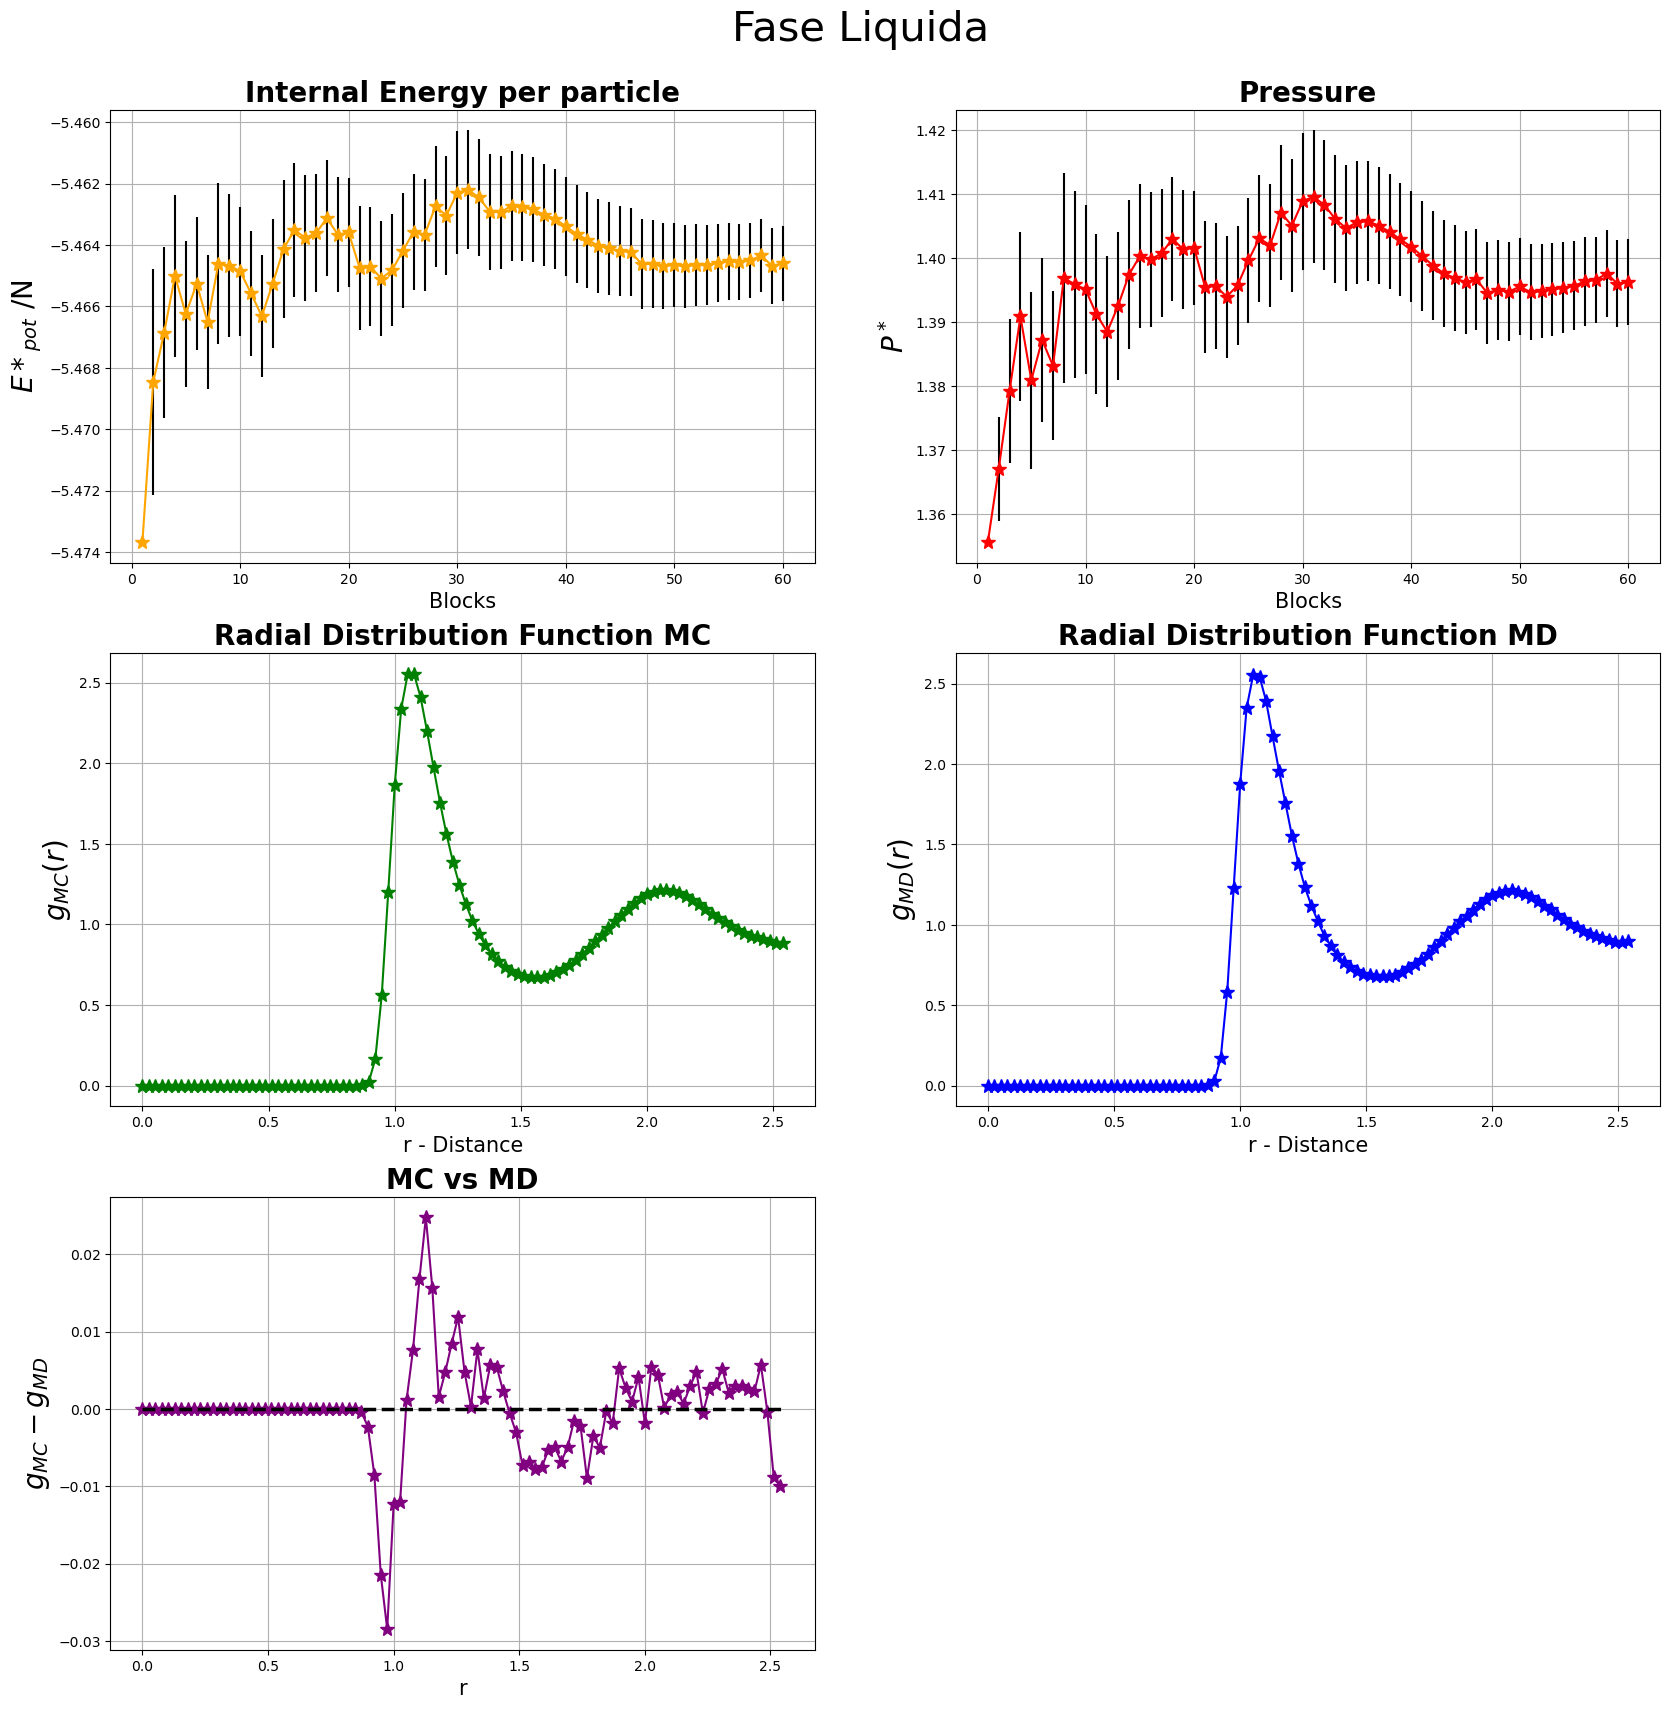

In [116]:
N =60
x = np.arange(N)+1 
plt.figure(figsize=(20,20))
colors = ['orange','red', 'green', 'blue', 'purple']
titles = ["Internal Energy per particle", "Pressure", "Radial Distribution Function MC", 
          "Radial Distribution Function MD" ,"MC vs MD"]
y_labels = [r"$E*_{pot}$ /N", r"$P^*$", r"$g_{MC}(r)$", r"$g_{MD}(r)$", r"$g_{MC} - g_{MD}$"]
files_name = ["epot", "pressure", "gfunction"]

for i in range(5):
    if (i<2):
        average, error = np.loadtxt("es7.4_metro/liquido/output_"+files_name[i]+".dat", usecols = (3, 4), 
                                    delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(x, average, yerr=error, color= colors[i], ecolor ='black', marker = '*', markersize = '10') 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("Blocks", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==2):
        r, average_mc, err_mc  = np.loadtxt("es7.4_metro/liquido/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)

        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_mc, yerr=err_mc, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==3):
        r, average_md, err_md  = np.loadtxt("es7.4_verlet/liquido/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_md, yerr=err_md, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if(i==4):
        plt.subplot(3, 2, i+1)
        plt.plot(r, average_mc - average_md, color=colors[i], marker = '*', markersize = '10' ) 
        plt.hlines(0, 0.0, 2.55, colors='black', linestyles='dashed', linewidth =2.5)
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
       
plt.suptitle ("Fase Liquida", fontsize =30, y=0.93)

plt.show()

### Fase Gassosa

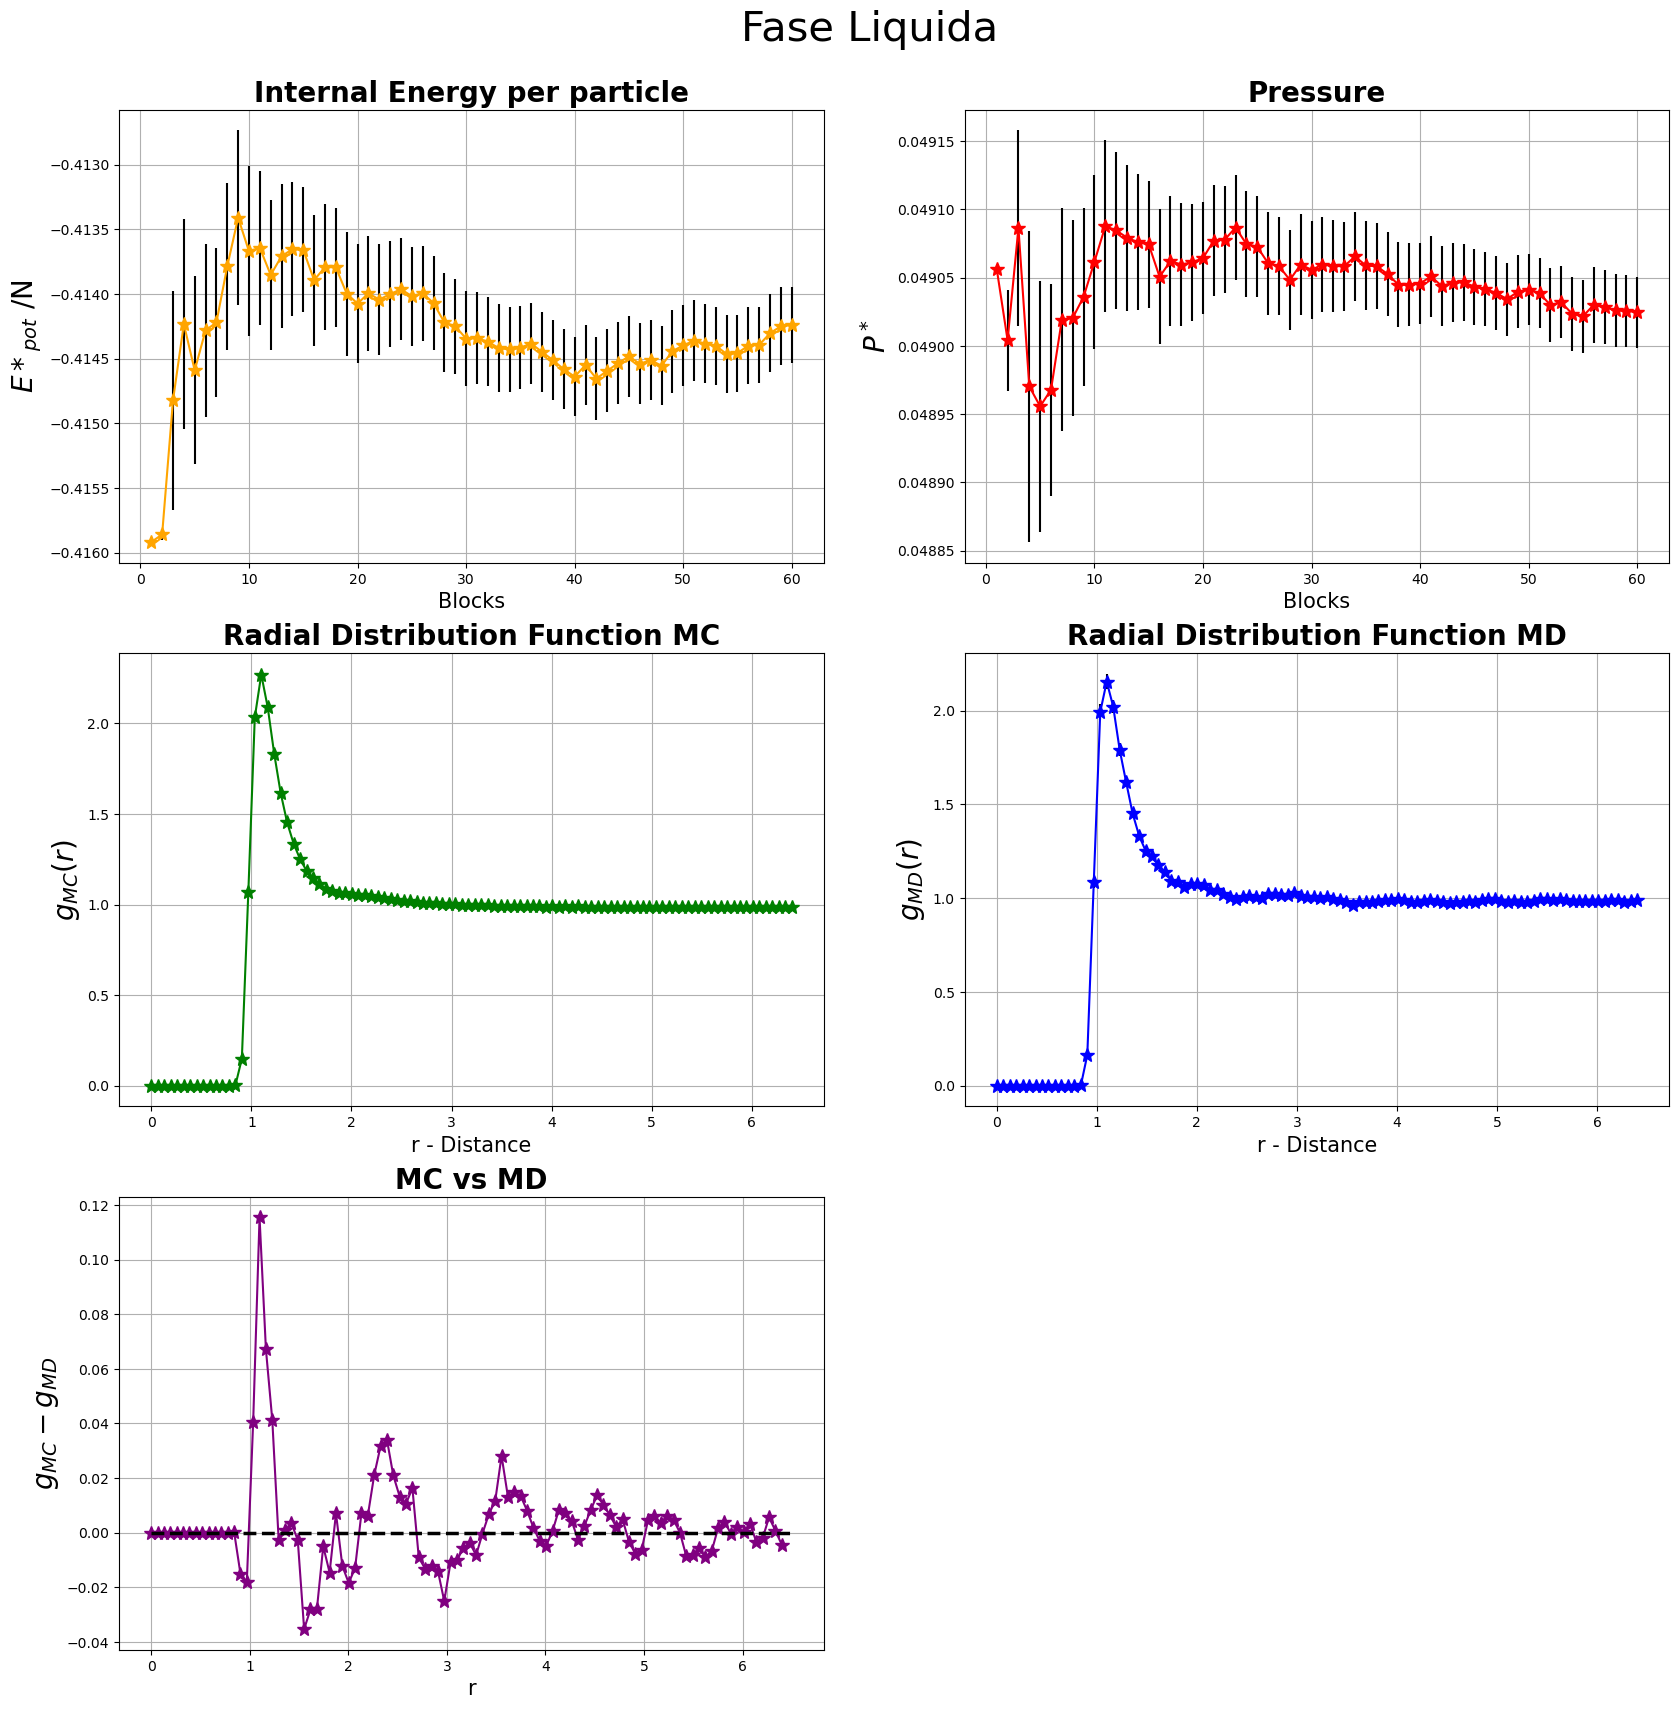

In [118]:
N =60
x = np.arange(N)+1 
plt.figure(figsize=(20,20))
colors = ['orange','red', 'green', 'blue', 'purple']
titles = ["Internal Energy per particle", "Pressure", "Radial Distribution Function MC", 
          "Radial Distribution Function MD" ,"MC vs MD"]
y_labels = [r"$E*_{pot}$ /N", r"$P^*$", r"$g_{MC}(r)$", r"$g_{MD}(r)$", r"$g_{MC} - g_{MD}$"]
files_name = ["epot", "pressure", "gfunction"]

for i in range(5):
    if (i<2):
        average, error = np.loadtxt("es7.4_metro/gas/output_"+files_name[i]+".dat", usecols = (3, 4), 
                                    delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(x, average, yerr=error, color= colors[i], ecolor ='black', marker = '*', markersize = '10') 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("Blocks", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==2):
        r, average_mc, err_mc  = np.loadtxt("es7.4_metro/gas/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)

        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_mc, yerr=err_mc, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if (i==3):
        r, average_md, err_md  = np.loadtxt("es7.4_verlet/gas/output_"+files_name[2]+".dat", usecols = (0, 1, 2), 
                                            delimiter=' ', unpack = True)
        plt.subplot(3, 2, i+1)
        plt.errorbar(r, average_md, yerr=err_md, color=colors[i], ecolor ='black', marker = '*', markersize = '10' ) 
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r - Distance", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
    if(i==4):
        plt.subplot(3, 2, i+1)
        plt.plot(r, average_mc - average_md, color=colors[i], marker = '*', markersize = '10' ) 
        plt.hlines(0, 0.0, 6.5, colors='black', linestyles='dashed', linewidth =2.5)
        plt.grid(True)
        plt.title(titles[i], fontweight='bold', fontsize = 20)
        plt.xlabel ("r", fontsize =15)
        plt.ylabel (y_labels[i], fontsize =20)
       
plt.suptitle ("Fase Liquida", fontsize =30, y=0.93)

plt.show()

## Osservazioni

Possiamo osservare come le due funzioni di distribuzione radiale calcolate in ensemble canonico col Metropolis e in microcanonico con l'algoritmo di Verlet siano compatibili tra di loro. Questo ci mostra che campionare il peso di Boltzamnn, ad esempio con l'algoritmo di Metropolis, e sparare "a caso" particelle nello spazio e' perfettamente equivalente a generare configurazioni risolvendo le Equazioni del Moto tramite Verlet: la Meccanica Statistica e' vera e funziona!

